In [1]:
from scripts.neuron_signal_generator import generate_signal
from scripts.noise_and_filtering import generate_electrode_signal
from scripts.simulator import simulate_recording
from scripts.reduce import dimensional_reduction
from scripts.clustering import get_clusters

from classes.sorter import SpikeSorter
import numpy as np

# from scripts.spike_extraction import get_waveform_data

In [2]:
# generate signal
neuron_signal = generate_signal()

generate_electrode_signal(
    signal=neuron_signal,
    decay_type='square',
    decay_rate=2,
    noise_type='gaussian',
    noise_std=0.5,
    filter_type='bandpass',
    low=500,
    high=3000
)

placements = [2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0]
neuronParams = {"neuron_type": "standard", "lambda": 14, "v_rest": -70, "v_thres": -10, "t_ref": 0.02, "fix_random_seed": True}
processingParams = {"decay_type": "square", "decay_rate": 2, "noise_type": "gaussian", "noise_std": 0.5, "filter_type": "none", "low": 500, "high": 3000}

time, filtered_signals = simulate_recording(placements, neuronParams, processingParams)

In [3]:
def get_waveform_data(signals, multiplier, waveform_duration):

    # intialise the spike sorter
    sorter = SpikeSorter(threshold_factor=multiplier, sample_rate=25000, waveform_duration=waveform_duration)

    # get the spikes for each recording
    spikes = sorter.get_spikes(signals)

    # convert the spikes into a numpy array
    spike_indices = np.array(spikes)

    # neuron spikes is used to determine the true labels of the spike data, so we'll just give an empty array
    neuron_spikes = []

    #### something not working here

    # get the locations of all the spikes detected by all channels, and true spike posititons
    merged_spike_indices, true_labels = sorter.merge_spike_indices(spike_indices, neuron_spikes, tolerance=30)

    # extract the waveform data from each of the identified spikes across all electrodes
    waveforms, waveform_info = sorter.get_all_waveforms(
        signals, 
        merged_spike_indices, 
        recenter=True,
        # visualise=True,
        labels=true_labels 
    )

    return waveforms, waveform_info


In [4]:
data = {
    "signals": filtered_signals,
    "extractionParams": {
        "thresholdMultiplier": 4,
        "waveformDuration": 0.3
    }
}

signals = data["signals"]
extraction_data = data["extractionParams"]
multiplier, waveform_duration = extraction_data["thresholdMultiplier"], extraction_data["waveformDuration"]

waveforms, waveform_info = get_waveform_data(signals, multiplier, waveform_duration)

waveforms = waveforms.tolist()
waveform_info = waveform_info.tolist()

In [5]:
model = "umap"
n_components = 2

reduced_data = dimensional_reduction(model=model, n_components=n_components, waveforms=waveforms)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/umap/umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/umap/umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/umap/umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


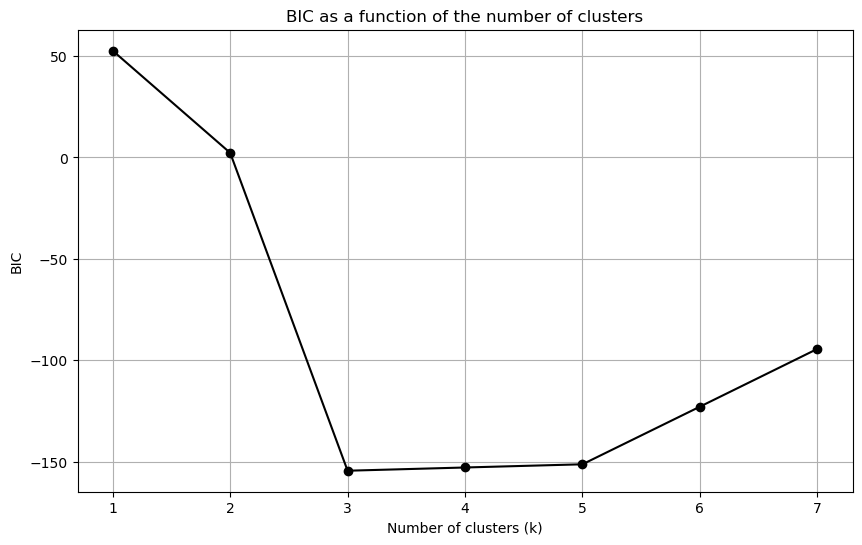

In [13]:
cluster_type, k_type, k = 'gmm', 'bic', 4

cluster_data = get_clusters(cluster_type, k_type, k, reduced_data)

In [14]:
cluster_data

{'ind': [1, 1, 1, 2, 0, 0, 0],
 'm': array([[ 17.08943939,   5.1204071 , -14.99848811, -18.37742678,
          -3.00281135,  -9.50741673],
        [ 16.09463596,   5.375573  , -15.66314411, -19.16470718,
          -3.99449023, -10.01720842],
        [ 17.45162964,   6.27665854, -13.83083153, -18.86649895,
          -3.05498672,  -8.46614933]]),
 'S': array([[[ 2.18812125e-01,  5.18650207e-02,  2.18765723e-01,
           6.63965537e-02,  1.07670408e-01, -2.56984542e-01],
         [ 5.18650207e-02,  1.26037116e-01,  1.06829137e-01,
          -9.62690538e-02,  1.73611256e-01, -1.32850553e-01],
         [ 2.18765723e-01,  1.06829137e-01,  2.45292201e-01,
           1.22466668e-02,  1.79224052e-01, -2.91700471e-01],
         [ 6.63965537e-02, -9.62690538e-02,  1.22466668e-02,
           1.30446694e-01, -1.13158820e-01, -7.14030271e-03],
         [ 1.07670408e-01,  1.73611256e-01,  1.79224052e-01,
          -1.13158820e-01,  2.45792089e-01, -2.20114994e-01],
         [-2.56984542e-01, -1.328